## <font color='Green'>1.Importing Libraries</h2></font>


In [487]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder



## <font color='Green'>2.Data Reading</h2></font>


In [490]:
dataset = pd.read_csv('data_science_challenge_data.csv')
dataset.head()

,neighbourhood,price,size,bedrooms,bathrooms,building
0,SNR,130000.0,1300.0,2,3.0,Building_263
1,ZMS,140000.0,1185.0,1,2.0,Building_25
2,ZMS,250000.0,2050.0,3,5.0,Building_324
3,ZMS,250000.0,3860.0,4,5.0,Building_353
4,SNR,170000.0,1896.0,3,4.0,Building_280


In [492]:
print(dataset.columns)

Index(['neighbourhood', 'price', 'size', 'bedrooms', 'bathrooms', 'building'], dtype='object')


In [494]:
dataset.describe().T


,count,mean,std,min,25%,50%,75%,max
price,67107.0,219911.781497,5.882342e+06,22000.0,99000.0,130000.0,165000.0,565352964.0
size,67107.0,1621.593040,9.049481e+03,-755.0,840.0,1200.0,1637.0,1170000.0
bedrooms,67107.0,1.654969,1.008304e+00,0.0,1.0,2.0,2.0,12.0
bathrooms,63657.0,2.403066,1.077319e+00,1.0,2.0,2.0,3.0,12.0


## <font color='Green'>3.Target Value Analysis(Price)</h2></font>



Skewness of SalePrice: 89.90


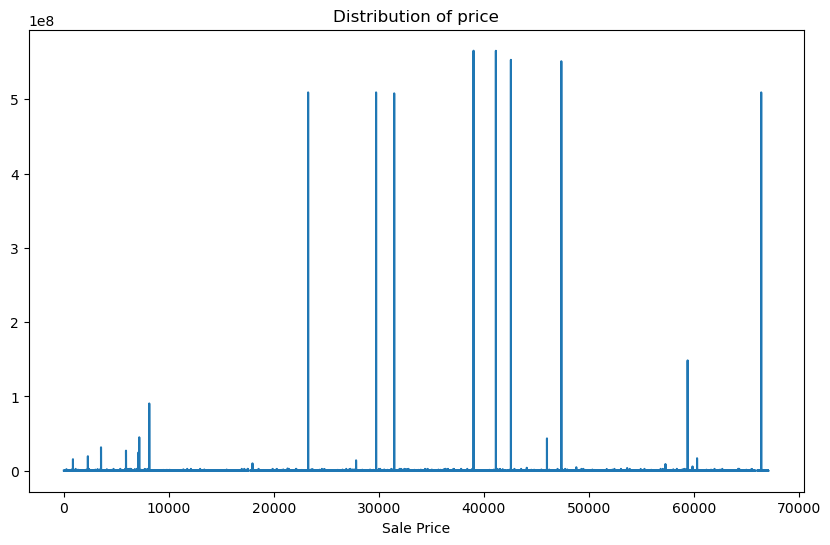

Skewness of Log-Transformed SalePrice: 2.36


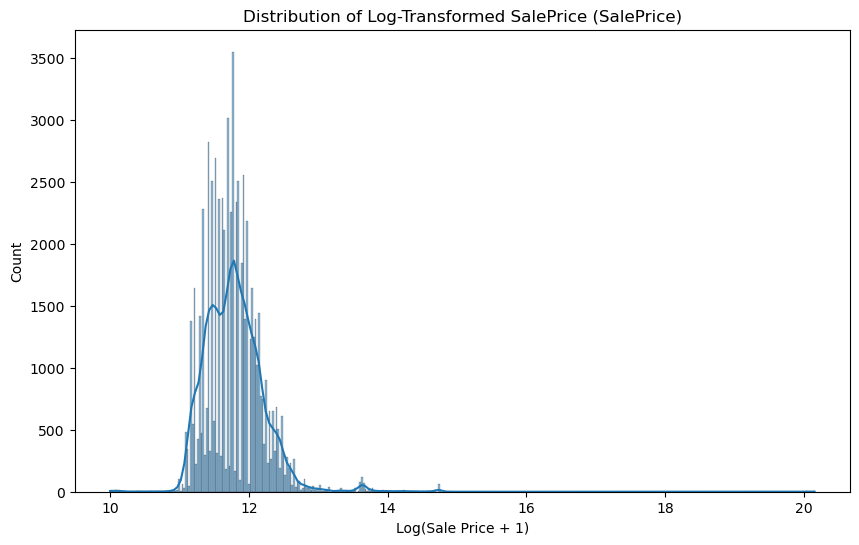

In [497]:
# Analyze the target variable 'price'
plt.figure(figsize=(10, 6))
plt.plot(dataset['price'])
plt.title('Distribution of price')
plt.xlabel('Sale Price')
print(f"\nSkewness of SalePrice: {dataset['price'].skew():.2f}") # Check skewness
plt.show()




# Apply log transformation to SalePrice to reduce skewness (common practice)
dataset['SalePrice'] = np.log1p(dataset['price']) # log1p handles potential 0 values safely

plt.figure(figsize=(10, 6))
sns.histplot(dataset['SalePrice'], kde=True)
plt.title('Distribution of Log-Transformed SalePrice (SalePrice)')
plt.xlabel('Log(Sale Price + 1)')
print(f"Skewness of Log-Transformed SalePrice: {dataset['SalePrice'].skew():.2f}") # Check skewness after transform
plt.show()
# Much better distribution after log transformation. We'll predict this log value.



In [498]:
dataset['SalePrice'].max()

20.152960810870557

In [499]:
dataset['price'].value_counts()

price
130000.0    3133
120000.0    2920
100000.0    2602
90000.0     2421
95000.0     2381
            ... 
76999.0        1
76500.0        1
96500.0        1
257268.0       1
207000.0       1
Name: count, Length: 943, dtype: int64

In [500]:
dataset.shape

(67107, 7)

In [505]:
dataset['SalePrice'].value_counts()

SalePrice
11.775297    3133
11.695255    2920
11.512935    2602
11.407576    2421
11.461643    2381
             ... 
11.251561       1
11.245059       1
11.477309       1
12.457878       1
12.240479       1
Name: count, Length: 943, dtype: int64

## <font color='Red'>4.Missing Value Analysis¶</h2></font>


In [508]:
# Check for missing values
missing = dataset.isnull().sum().sort_values(ascending=False)
missing = missing[missing > 0] # Filter only columns with missing values
missing_perc = (missing / len(dataset)) * 100

missing_data = pd.DataFrame({'Missing Count': missing, 'Percentage (%)': missing_perc})
print("\n--- Features with Missing Values ---")
print(missing_data.head(20)) # Show top 20 features with missing values



--- Features with Missing Values ---
           Missing Count  Percentage (%)
building            6039        8.999061
bathrooms           3450        5.141043


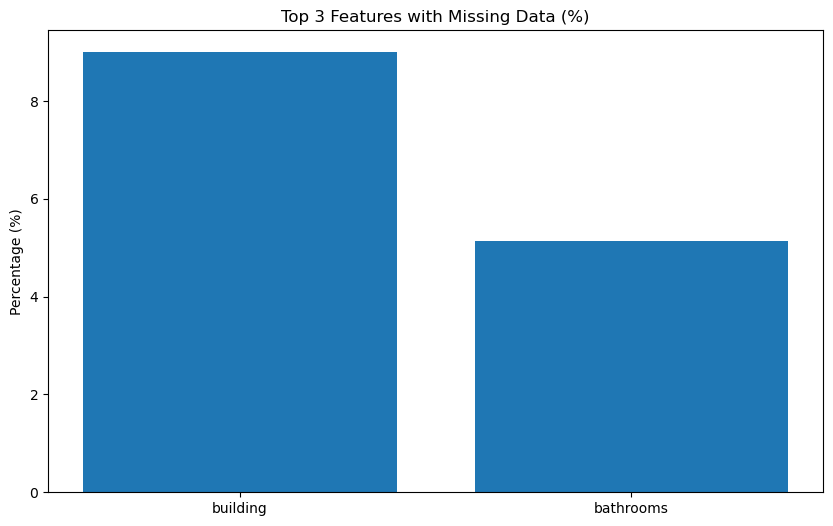

In [510]:
plt.figure(figsize=(10, 6))

plt.bar(missing_data.index,missing_data['Percentage (%)'],label='bar')
plt.title('Top 3 Features with Missing Data (%)')
plt.ylabel('Percentage (%)')
plt.show()

## <font color='Red'>5.Feature Correlations¶</h2></font>


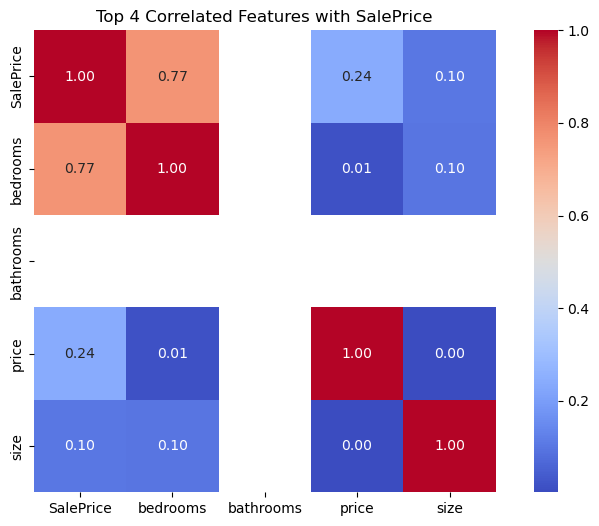

In [516]:
# Explore correlations with the target variable (Log Transformed)
# Select only numerical features for correlation matrix (including the log target)
numeric_cols = dataset.select_dtypes(include=np.number).columns.tolist()
corrmat = dataset[numeric_cols].corr() # Use df_train as it now contains SalePrice_Log
nominal_cols = [col for col in categorical_cols]


# Find correlations with SalePrice_Log, sort them
k = 5 # Number of top correlations to show
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(dataset[cols].values.T)

plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, square=True, fmt='.2f', cmap='coolwarm',
            yticklabels=cols.values, xticklabels=cols.values)
plt.title(f'Top {k-1} Correlated Features with SalePrice')
plt.show()

## <font color = 'red'>6.Preprocessing</font>

In [519]:
# Define target (using log-transformed price) and features
y = dataset['SalePrice']
X = dataset.drop(['price', 'SalePrice'], axis=1)

print(f"Shape of features X before preprocessing: {X.shape}")

# Identify numerical and categorical columns
numerical_cols = X.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X.select_dtypes(include='object').columns.tolist()

Shape of features X before preprocessing: (67107, 5)


In [521]:
numerical_cols

['size', 'bedrooms', 'bathrooms']

In [523]:
categorical_cols

['neighbourhood', 'building']

In [525]:
X.isna().sum()

neighbourhood       0
size                0
bedrooms            0
bathrooms        3450
building         6039
dtype: int64

In [527]:
cat_na_means_none = ['bathrooms', 'building']

In [529]:
cat_na_means_none

['bathrooms', 'building']

In [531]:
dataset.building.value_counts()

building
Building_101    1672
Building_320    1487
Building_197    1376
Building_163    1178
Building_98     1034
                ... 
Building_222       1
Building_294       1
Building_81        1
Building_327       1
Building_86        1
Name: count, Length: 353, dtype: int64

In [533]:
X['bathrooms'].fillna(X['bathrooms'].median(), inplace=True)


In [535]:
X

,neighbourhood,size,bedrooms,bathrooms,building
0,SNR,1300.0,2,3.0,Building_263
1,ZMS,1185.0,1,2.0,Building_25
2,ZMS,2050.0,3,5.0,Building_324
3,ZMS,3860.0,4,5.0,Building_353
4,SNR,1896.0,3,4.0,Building_280
...,...,...,...,...,...
67102,ZMS,830.0,1,2.0,Building_69
67103,ZMS,923.0,1,2.0,Building_320
67104,ZMS,1196.0,2,3.0,Building_240
67105,ZMS,922.0,1,2.0,NaN


In [537]:
X['building'].fillna(X['building'].mode()[0], inplace=True)


In [539]:
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])



nominal_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)) # handle_unknown='ignore' drops unseen categories
])

# Create the ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('nom', nominal_transformer, nominal_cols)
    ],
    remainder='passthrough' # Keep any columns not specified (shouldn't be any if lists are correct)
)

In [541]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_test.shape}")

# Now fit the preprocessor on the training data and transform both sets
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

X_train shape: (53685, 5)
X_val shape: (13422, 5)


In [543]:
X_train_processed

array([[-0.00890805,  0.34397375,  0.58740414, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.09924622,  2.33612339,  2.48835002, ...,  0.        ,
         0.        ,  0.        ],
       [-0.06885641,  0.34397375,  0.58740414, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.05319979,  0.34397375, -0.3630688 , ...,  0.        ,
         0.        ,  0.        ],
       [-0.11706231, -1.64817588, -1.31354174, ...,  0.        ,
         0.        ,  0.        ],
       [-0.05628992, -0.65210106, -1.31354174, ...,  0.        ,
         0.        ,  0.        ]])

In [545]:
# Define models
models = {
    "Ridge Regression": Ridge(alpha=10, random_state=42), # Alpha can be tuned
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, max_depth=15, min_samples_split=5, min_samples_leaf=3), # Example parameters, tuning needed
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42) # Example parameters
}

# Dictionary to store results
results = {}

In [547]:
print("\n--- Model Training and Evaluation ---")
for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Train the model on processed training data and log-transformed target
    model.fit(X_train_processed, y_train) # Use DataFrame or NumPy array

    # Make predictions on the validation set (log scale)
    y_pred_log_test = model.predict(X_test_processed) # Use DataFrame or NumPy array

    # Evaluate using RMSE on the log scale (proxy for RMSLE)
    rmse_log = np.sqrt(mean_squared_error(y_test, y_pred_log_test))
    
    # Also calculate R-squared and MAE on the log scale
    r2_log = r2_score(y_val, y_pred_log_test)
    mae_log = mean_absolute_error(y_val, y_pred_log_test)
    results[name] = {
        'model': model,
        'RMSE_log': rmse_log,
        'R2_log': r2_log,
        'MAE_log': mae_log,
        'y_pred_log_val': y_pred_log_test
    }

    print(f"--- Results for {name} ---")
    print(f"Validation RMSE (log scale): {rmse_log:.5f}")
    print(f"Validation R-squared (log scale): {r2_log:.5f}")
    print(f"Validation MAE (log scale): {mae_log:.5f}")




--- Model Training and Evaluation ---

Training Ridge Regression...
--- Results for Ridge Regression ---
Validation RMSE (log scale): 0.23447
Validation R-squared (log scale): 0.72286
Validation MAE (log scale): 0.10207

Training Random Forest...
--- Results for Random Forest ---
Validation RMSE (log scale): 0.22067
Validation R-squared (log scale): 0.75452
Validation MAE (log scale): 0.09726

Training Gradient Boosting...
--- Results for Gradient Boosting ---
Validation RMSE (log scale): 0.22663
Validation R-squared (log scale): 0.74107
Validation MAE (log scale): 0.11034


In [548]:
# Display comparison summary based on RMSE (log scale)
print("\n--- Model Comparison (Validation Set Performance) ---")
comparison_data = []
for name, result in results.items():
    comparison_data.append({
        "Model": name,
        "RMSE (log scale)": result['RMSE_log'],
        "R-squared (log scale)": result['R2_log'],
        "MAE (log scale)": result['MAE_log'],
        # "RMSLE (original scale)": result.get('RMSLE', 'N/A') # Use .get for safety if RMSLE wasn't calculated
    })

comparison_df = pd.DataFrame(comparison_data)
# Sort by RMSE (lower is better)
print(comparison_df.sort_values(by='RMSE (log scale)', ascending=True))



--- Model Comparison (Validation Set Performance) ---
               Model  RMSE (log scale)  R-squared (log scale)  MAE (log scale)
1      Random Forest          0.220670               0.754521         0.097261
2  Gradient Boosting          0.226635               0.741070         0.110336
0   Ridge Regression          0.234471               0.722855         0.102075



--- Plotting Actual vs Predicted for Best Model: Random Forest ---


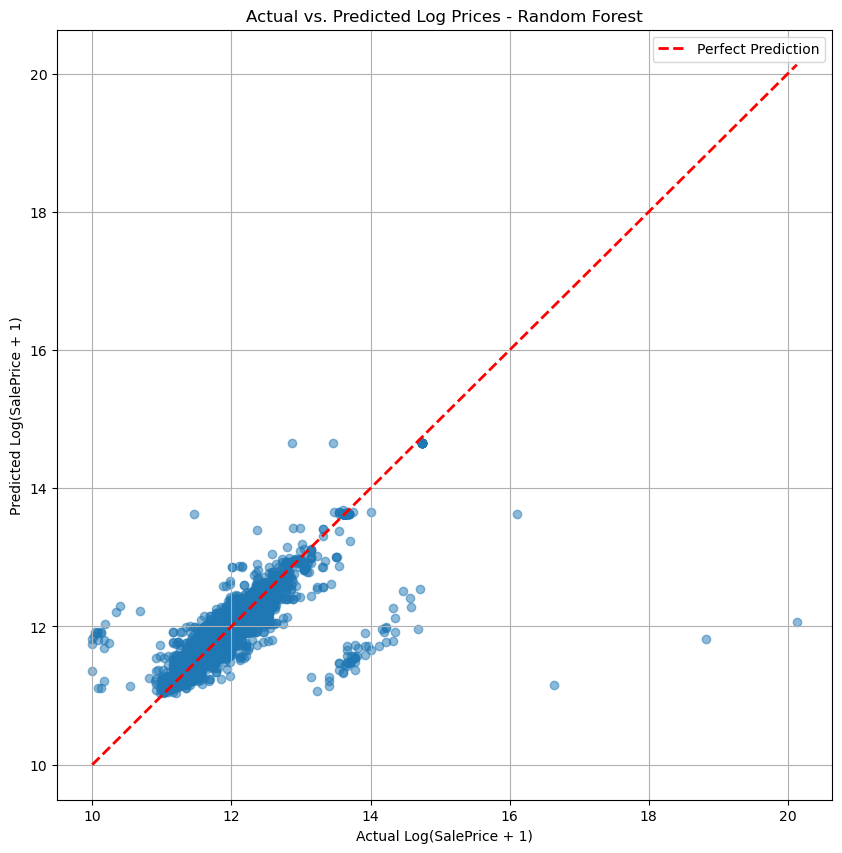

In [549]:
# Plot Actual vs Predicted for the best model (example: find best based on RMSE_log)
best_model_name = comparison_df.sort_values(by='RMSE (log scale)', ascending=True).iloc[0]['Model']
best_model_preds = results[best_model_name]['y_pred_log_val']

print(f"\n--- Plotting Actual vs Predicted for Best Model: {best_model_name} ---")

plt.figure(figsize=(10, 10))
plt.scatter(y_val, best_model_preds, alpha=0.5)
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], '--', color='red', lw=2, label='Perfect Prediction')
plt.xlabel("Actual Log(SalePrice + 1)")
plt.ylabel("Predicted Log(SalePrice + 1)")
plt.title(f"Actual vs. Predicted Log Prices - {best_model_name}")
plt.legend()
plt.grid(True)
plt.show()

In [573]:
predictionModel = models['Random Forest']
predictionModel

RandomForestRegressor(max_depth=15, min_samples_leaf=3, min_samples_split=5,
                      n_jobs=-1, random_state=42)

In [583]:
pickledModel.predict(X_test_processed[0].reshape(1,-1))

array([11.94181838])

In [552]:
y.min()

9.99884318585288

In [553]:
y.max()

20.152960810870557

In [554]:
y_pred_actual = np.exp(17.94181838)
y_pred_actual

61948774.26698388

In [555]:
dataset.price.min()

22000.0

In [556]:
dataset.price.max()

565352964.0

In [567]:
#Pickling

In [571]:
import pickle  

In [577]:
pickle.dump(predictionModel,open('pricePredModel.pkl','wb'))

In [581]:
pickledModel = pickle.load(open('pricePredModel.pkl','rb'))